In [1]:
from get_mnist_features import get_gp_mnist_data
from keras.datasets import mnist
import numpy as np
import scipy.io

Using TensorFlow backend.


In [2]:
# %%time
# (mnist_train, X_train, y_train) ,(mnist_test, X_test, y_test) = get_gp_mnist_data('my_model.h5')
mnist_train = np.load('data/mnist_train.npy')
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
mnist_test = np.load('data/mnist_test.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 128)
(60000,)
(10000, 128)
(10000,)


# Train a GP on the features

In [37]:
import gpflow
import tensorflow as tf

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [38]:
num_classes = 10
num_features = 128

In [39]:
%%time
X_train = X_train.astype('float64').reshape(-1,num_features)
y_train = y_train.astype('float64').reshape(-1,1)
kernel = gpflow.kernels.Matern32(num_features) + gpflow.kernels.White(num_features, variance=0.01)
likelihood = gpflow.likelihoods.MultiClass(num_classes)
Z=X_train[::5].copy()
num_latent=num_classes
whiten=True
q_diag=True
m = gpflow.models.SVGP(X_train, y_train, 
                       kern=kernel, 
                       likelihood=likelihood,
                       Z=Z, 
                       num_latent=num_latent,
                       whiten=whiten, 
                       q_diag=q_diag)

m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

CPU times: user 1.27 s, sys: 70.7 ms, total: 1.34 s
Wall time: 1.33 s


In [28]:
%%time
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 72.670209
  Number of iterations: 1
  Number of functions evaluations: 3
CPU times: user 2.67 s, sys: 38.5 ms, total: 2.71 s
Wall time: 2.69 s


In [29]:
%%time
X_test = X_test.astype('float64').reshape(-1,num_features)
print(X_test.shape)
p, var = m.predict_y(X_test)

(10000, 128)
CPU times: user 6.5 s, sys: 149 ms, total: 6.64 s
Wall time: 919 ms


In [30]:
print(p.shape)

(10000, 10)


In [31]:
predictions = np.argmax(p, axis=-1)
accuracy = len(np.argwhere(predictions == y_test))/len(predictions)
print(accuracy)
print(classification_report(y_test, predictions))

0.2106
             precision    recall  f1-score   support

          0       0.15      0.19      0.17       980
          1       0.00      0.00      0.00      1135
          2       0.19      1.00      0.32      1032
          3       0.00      0.00      0.00      1010
          4       0.00      0.00      0.00       982
          5       0.27      1.00      0.43       892
          6       0.00      0.00      0.00       958
          7       0.00      0.00      0.00      1028
          8       0.00      0.00      0.00       974
          9       0.00      0.00      0.00      1009

avg / total       0.06      0.21      0.09     10000



/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
incorrect_indices = np.argwhere(predictions != y_test)
correct_indices = np.argwhere(predictions == y_test)
print(len(incorrect_indices))

7894


[0.08995138 0.08995138 0.08995138 0.08995138 0.08995138 0.08995138
 0.08995138 0.08995138 0.08995138 0.08995138]
Correct class: [4]


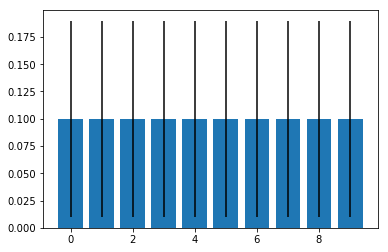

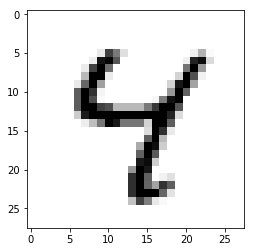

In [33]:
%matplotlib inline
index = incorrect_indices[5]
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

In [21]:
# %matplotlib inline
index = correct_indices[5496]
print(index)
print(p[index].squeeze())
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

IndexError: index 5496 is out of bounds for axis 0 with size 2106

In [22]:
correct_indices_correct_classes = np.argmax(p[correct_indices], axis=-1).reshape(-1)
correct_indices_correct_var = temp[np.arange(len(correct_indices)), correct_indices_correct_classes]
np.argmax(correct_indices_correct_var)

NameError: name 'temp' is not defined

## Noisy mnist

In [99]:
def load_data():
    rows, cols = 28, 28
    nb_classes = 10

    DATA_DIR = 'data/mnist-with-awgn.mat'
    mat = scipy.io.loadmat(DATA_DIR)

    X = mat['images']
    Y = mat['labels']

    # Move last column to front
    X = np.rollaxis(X, 2)

    # Reshape and format input
    X = X.reshape(X.shape[0], rows, cols, 1)
    X = X.astype('float32')
    X /= 255.0

    # Hot encoding
    Y = Y.astype(int)
    Y = np_utils.to_categorical(Y, nb_classes)

    # Divide into test and train sets
    perm = np.random.permutation(X.shape[0])

    train_size = 13000

    X_train = X[perm[:train_size]]
    X_test = X[perm[train_size:]]

    Y_train = Y[perm[:train_size]]
    Y_test = Y[perm[train_size:]]

    return (X_train, Y_train, X_test, Y_test)

In [102]:
(X_train, Y_train, X_test, Y_test) = load_data()

AttributeError: module 'scipy' has no attribute 'io'